# Modelisation of the impact of social tracing app: a contact network model

by Alexandre Variengien, Simon Dupouy, Ghuilem Niot and Timothé Picavet

contact : [alexandre.variengien@ens-lyon.fr]



### Context of creation

This model was created during the "Hack COVID19" Hackathon, which took place between the 10th and the 12th of April and was organized by HEC and l'École Polytechnique.
It was created to model the impact of the adoption of a social tracing app like STOP COVID in France on the spread of the pandemic.
Its primary goal is to show the influence of parameters such as the proportion of users using the app in the global population or the account of the applicaiton notification: after a suspected transmission is notified by the app, will a citizen choose to directly quarantine himself?

### Motivation

We are students in computer science at the ENS de Lyon, so we aren't expert in the field of epidemiology. This model doesn't aim to provide precise predictions for the future of the pandemic.
However, it is easily understandable and still reasonnably effective to get an overall sense of what we could expect from a social tracing app.
More specifically, it gives a good intuition about the impact a social tracing app may have on the epidemic depending on the adoption rate of the app.
You may try changing the parameters to convince yourself that targeted quarantining of suspected cases can lead to a great limitation of the spread - if it is well adopted by the population.
So feel free to play with our model!

### Bibliography

Contact network epidemiology is a paradigm to modelize an epidemic, it has been widely studied and it can account for the discrepency of transmission between individuals.
It has been discussed that this approach is suited to model an epidemic as SARS-CoV-1 in [1].
Moreover, the structure of the chosen graph has a great impact on the final extent of the outbreak, as discussed in [2].
We chose two models for the graph:
- a model using an exponential law for the degrees distribution - which seems suited for a disease such as SARS in urban areas [3]
- a method from [3] for building the network by stages: first we build highly connected households, then the connections between them.

As for the epidemiological parameters of the disease, we adapted parameters from [4] to be suited for our model.
Also, other models for the impact of a social tracing app have been proposed such as in [4] and [5].

### The model

Each vertex of the graph is an individual that can be : Healthy, Infected with symptoms, Infected without symptoms, Dead or Recovered.
At each step we go trough all the edges and with the probability given by these edges, there is a contact between the individuals.
If one of them is infected and the other healthy, it gives the infection to the other. With a propability of detection, the app notices this contact.

After that, if an individual infected get symtoms, the app warns with a certain probability all the persons he met in the past 14 days. 
All the warned individual quarantine themselves for 14 days themselves with a certain propability.

### Limits of the model

The most critial limit of the model is the duration of the infection period. As we use a Markov chain like modelisation at the scale of the individual, the expected time spent in the "Infected" state follows a geometric law as opposed to a law closer to log-normal mentioned in [4].
Moreover, the parameters of the initial graph were determined to get an average number of contact of around 30/days without much support nor information found about this.

With this fixed average of contacts per day, the average duration of the epidemic and R0 estimated by [4], we computed the propability of transmission during a contact.


### References

* [1] Contact network epidemiology: Bond percolation applied to infectious disease prediction and control, Lauren Ancel Meyers 
* [2] Contact Network Epidemiology: Mathematical Methods of Modeling a Mutating Pathogen on a Two-type Network by Robert L. Seilheimer
* [3] Network theory and SARS: predicting outbreak diversity by Lauren Ancel Meyers & al.
* [4] Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing. - PubMed - NCBI
* [5] The Impact of Contact Tracing in Clustered Populations by Thomas House & Matt J Keeling

### Results

Our model is based on a graph simulation

Here is the initial state:
<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/init_state.png" alt="init state" style="width: 500px;"/>

Color correspondance:

Green -> sane

Red -> infected without symptoms

Pink -> infected with symptoms

Blue -> Cured

Black -> Dead

Let's see what happens when nobody installs the app.

Day 20:

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_20_noapp.png" alt="no app, day 20" style="width: 500px;"/>

After 50 days, almost everyone was infected (because almost everyone is cured):

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_50_no_app.png" alt="no app, day 50" style="width: 500px;"/>

Now, if everybody uses the app:

Day 10:

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_10_app.png" alt="app, day 10" style="width: 500px;"/>

Day 20:

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_20_app.png" alt="app, day 20" style="width: 500px;"/>

Day 30:

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_30_app.png" alt="app, day 30" style="width: 500px;"/>

After 50 days, a non negligable amount of people are sane:

<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/state_50_app.png" alt="app, day 50" style="width: 500px;"/>

Moreover, we ploted the evolution of these numbers as a function of time:

With the app :
<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/with_app.png" alt="app, day 50" style="width: 500px;"/>

Without the app :
<img src="https://raw.githubusercontent.com/GuilhemN/covid-19-tracing-app-modelling/master/images/no_app.png" alt="app, day 50" style="width: 500px;"/>

We can see that the app causes targeted quarantine for persons who are at high risk of infection.
After the first quarantine, the epidemic can spread again, causing the app to trace and quarantine risked persons again. That's why we see these oscillations.
Also, the pink curve shows the total number of infection that occured without symptoms. The app significantly reduce this quantity by informing the persons who may have the virus really soon.
To conclude the use of the app has a significant impact on the evolution of the virus.
You can easily play with our interactive model at the end of the notebook !

All the visualisations of graphs were made with Gephi and the Force Atlas 2 algorithm.

# Parameters

In [1]:
# sliders
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# graph generation for exponential degrees distribution
nbIndividuals = 1000 # nbIndividus | number of people in the graph | nombre d'individus dans le graphe
deg_avg = 100 # | deg_moy | average number of connexions per person | le nombre moyen de connexions par personne
av_household_size = 6 # avergave size of household | la taille moyenne d'un foyer
household_proba = 1 # probability of meeting a person of the same household | la probabilité de contact par jour entre membres d'un même foyer
extern_contact_proba = 0.3 # probabilty of meeting a person of a different household | la probabilité de contact par jour entre personne de foyers différents

#average contact per day = 0.3*(100-6) + 6 = 34.2

#graph generation using organization in households
household_size = (2,6) #min and max size of an household (uniform distribution)
household_link = 0.9 #probability of contact between members of an household

communauty_size = 300 #number of households in the communauty
communauty_link = 0.3 #probability of contact across households
av_deg_by_household = 400 #number of link from a household

# average external degree of an individual : 400/4 (4 is the average size of an household)
#average contact per day = (400/4)*0.3 + 0.9*4 = 33.6



UtilApp = 0.8 # percentage of people having the app | la proportion d'utilisateurs de l'application dans la population générale
InitSane = 0.99 # InitSain | percentage of healthy people at start | la proportion de personnes saines à l'intant initial (les autres sont porteurs asymptomatiques)

# application
daysNotif = 14 # joursNotif

pDetection = 0.9
pReport = 0.9   # pSignalement
pQNotif = 0.8 # probablity of going into quarantine when recieving a notification | proba de mise en confinement lors de la réception d'une notification

# probas
pContamination = 0.02 # probabilty of contaminating another individual given a contact | proba de contaminer un autre individu alors qu'il y a eu contact
#we took R0 =2 etimate from [4] and : 34 contacts/day, an average time of infectiousness of 5+14 days
# So (5+14)*34*0.003 = 1.9 this is plausible given the estimate of R0

pAtoG = 0.12 # probability of going from asymptomatic state to cured | proba de passer de asymptomatique à guéri
pAtoIS = 0.06 # probability of going from asymptomatic state to symptomatic state | passage de asymptomatique à avec symptomes
pAtoD = 0.0 # probability of dying when asymptomatic | proba de décès
#average time infectious without symptoms : 1/(0.06+0.12) = 5.5 days of incubation period plausible according to [4]
#proportion of infected that will never have symptoms : 0.12/(0.06+0.12) = 66% plausible according to estimates (but a lot of uncertainty about that)

pIStoG = 0.07 # probability of going from symptomatic state to cured | proba de passer de avec symptomes à gueri
pIStoD = 0.003 # probability of dying when symptomatic 
#average time with symptoms : 1/(0.07+0.003) = 13.7 days : plausible according to [4]
#death rate when symptoms : 0.003/0.07 = 4.3% : plausible in France according to estimate of 1.6M cases with symptoms
#and 6 000 deaths the 3 April 
#https://www.mgfrance.org/publication/communiquepresse/2525-enquete-mg-france-plus-d-un-million-et-demi-de-personnes-prises-en-charge-par-leur-medecin-generaliste-pour-le-covid-19-entre-le-17-mars-et-le-3-avril

pQSymptoms = 0.9 # probability of going into quarantine when one has symptoms | proba confinement lors de détection des symptomes

confinementFactor = 100 # facteurConfinement | reduction factor applied to the probabilities when one is in quarantine | réduction des probas de rencontre lors du confinement
daysConfinement = 14 # jourConfinement | duration of the confinement/quarantine

# Libs and defs

In [3]:
# Librairies
import random
import math as m
import numpy as np

In [4]:
SANE = 0
ASYMP = 1
SYMP = 2
CURED = 3
DEAD = 4

nbS = 0
nbAS = 0
nbSane = 0
nbDead = 0
nbCured = 0
nbQuarantine = 0
nbInfectedByAS = 0

In [5]:
individuals = []
adj = []

# Graph generation

In [6]:
# graph initialisation based on exponential ditribution of degree

def init_graph():
    global nbSane
    global nbAS
    global nbInfectedByAS
    global individuals
    global adj
    global encounters
    
    individuals = []
    adj = []
    nbInfectedByAS = 0
    
    # creation of individuals
    for i in range(nbIndividuals):
        app = False
        if random.uniform(0,1) < UtilApp:
            app = True
        s = ASYMP
        if random.uniform(0,1) < InitSane:
            s = SANE
            nbSane +=1
        else:
            nbAS +=1
        individuals.append({"state": s, "confined": False, "daysConfinement": 0, "app": app})

    #affecting degrees to vertices
    degrees = np.around(np.random.exponential(deg_avg, nbIndividuals))

    #to get an even number of total degrees
    S = sum(degrees)
    if S%2 == 1:
        degrees[0] += 1
        S += 1

    adj = [[] for i in range(nbIndividuals)]
    while S > 0:
        #creating an edge
        [p1, p2] = np.random.choice(len(degrees), 2, replace=False, p=degrees/S)
        if degrees[p1] <= av_household_size or degrees[p2] <= av_household_size:
            adj[p1].append({"node" : p2, "proba" : household_proba})
            adj[p2].append({"node" : p1, "proba" : household_proba})
        else:
            adj[p1].append({"node" : p2, "proba" : extern_contact_proba})
            adj[p2].append({"node" : p1, "proba" : extern_contact_proba})
        degrees[p1] -= 1
        degrees[p2] -= 1
        S -= 2
    
    encounters = [[[] for jour in range(daysNotif)] for individual in range(nbIndividuals)]
#graph generation based on households organisation


def init_graph_household():
    global nbSane
    global nbAS
    global nbInfectedByAS
    global individuals
    global nbIndividuals
    global adj
    global encounters
    
    individuals = []
    adj = []
    nbInfectedByAS = 0
    

    #creation of the households
    adj = []

    for i in range(communauty_size):
        size = random.randint(household_size[0], household_size[1])
        nb = len(adj)
        for i in range(nb,nb+size):
            vois = []
            for j in range(nb,nb+size):

                if (i!=j):
                    vois.append({"node":j, "proba": household_link})
            adj.append(vois)

    #linkage of the households
    for i in range(av_deg_by_household*communauty_size):
        x1 = random.randint(0, len(adj)-1)
        x2 = random.randint(0, len(adj)-1)

        adj[x1].append({"node":x2, "proba": communauty_link})
        adj[x2].append({"node":x1, "proba": communauty_link})

    nbIndividuals = len(adj)
    
    # creation of individuals
    for i in range(nbIndividuals):
        app = False
        if random.uniform(0,1) < UtilApp:
            app = True
        s = ASYMP
        if random.uniform(0,1) < InitSane:
            s = SANE
            nbSane +=1
        else:
            nbAS +=1
        individuals.append({"state": s, "confined": False, "daysConfinement": 0, "app": app})
        
    encounters = [[[] for jour in range(daysNotif)] for individual in range(nbIndividuals)]


# Updating the graph

In [7]:
encounters = [[[] for jour in range(daysNotif)] for individual in range(nbIndividuals)]

In [8]:
def contamination(i, j):
    global nbSane
    global nbAS
    global nbInfectedByAS
    global individuals
    if individuals[i]['state'] == individuals[j]['state']:
        return
    if individuals[i]['state'] >= CURED or individuals[j]['state'] >= CURED:
        return # cannot infect cured or dead individuals | on ne peut pas contaminer les individus guéris ou décédés
    
    if individuals[i]['state'] == SANE:
        contamination(j, i)
        return
    
    if individuals[j]['state'] != SANE or random.random() > pContamination:
        return # no contamination
    
    if individuals[i]['state'] == ASYMP:
        nbInfectedByAS += 1

    nbSane -= 1
    nbAS += 1
    individuals[j]['state'] = ASYMP

In [9]:
# Step from a day to the next day | Passage au jour suivant du graphe
def step():
    global nbSane
    global nbS
    global nbAS
    global nbDead
    global nbCured
    global nbQuarantine
    global individuals
    
    for encounter in encounters:
        encounter.append([]) # will contain every encounter of the day | contiendra les nouvelles rencontres du jour

    # For each possible encounter | On constate toutes les rencontres entre individus
    for i in range(nbIndividuals):
        for edge in adj[i]:
            j = edge['node']
            if j < i:
                continue # only check one way of the edge | on ne regarde qu'un sens de chaque arête
            
            factor = 1
            if individuals[i]['daysConfinement'] > 0:
                factor *= confinementFactor
            if individuals[j]['daysConfinement'] > 0:
                factor *= confinementFactor
            
            # if i or j are in quarantine, reduce the probability that they meet | Si i et/ou j sont confinés, réduction de leur proba de rencontre
            if random.random() > edge['proba'] / factor: 
                continue # no encounter | pas de rencontre
        
            # if i and j have the app, we save their encounter | Si i et j ont l'appli, on note la rencontre
            if individuals[i]['app'] and individuals[j]['app'] and random.random() < pDetection: 
                encounters[i][-1].append(j) 
                encounters[j][-1].append(i)
            
            contamination(i, j)
    
    # handle new day | On passe au jour suivant
    nbQuarantine = 0
    for i in range(nbIndividuals):
        individuals[i]['daysConfinement'] -= 1
        if individuals[i]['daysConfinement'] > 0:
            nbQuarantine += 1

    # update the states | on met à jour les états des individus
    for i, individual in enumerate(individuals):
        if individual['state'] == ASYMP:
            action = random.random()
            if action < pAtoG:
                nbAS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pAtoIS:
                nbAS -= 1
                nbS += 1
                individual['state'] = SYMP
                
                # send the notifications (encounters[i] is empty if i hasn't the app | envoi des notifs (rencontres[i] vide si i n'a pas l'appli)
                if random.random() < pReport:
                    for daysEncounter in encounters[i]:
                        for contact in daysEncounter:
                            if random.random() < pQNotif:
                                individuals[contact]['daysConfinement'] = daysConfinement
                    
                    if random.random() < pQSymptoms: # go into quarantine if symptoms appear | mise en confinement à la détection des symptomes
                        individual['daysConfinement'] = daysConfinement
                
        elif individual['state'] == SYMP:
            action = random.random()
            if action < pIStoG:
                nbS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pIStoD:
                nbS -= 1
                nbDead += 1
                individual['state'] = DEAD
    
    # On supprime le plus vieux jour de l'historique
    for encounter in encounters:
        encounter.pop(0)
        
            

# Affichage

<IPython.core.display.Javascript object>


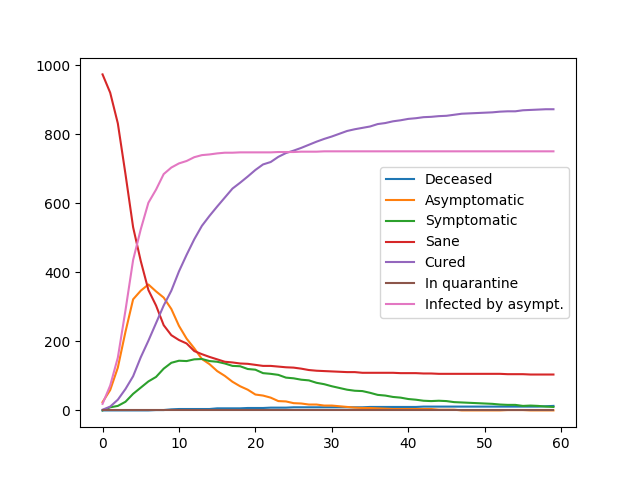

472


interactive(children=(FloatSlider(value=0.8, description='app_utilisation', max=1.0, step=0.01), FloatSlider(v…

<function __main__.update_prob(app_utilisation, report_to_app, quarantine_when_notif)>

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib notebook

init_graph()

fig = plt.figure()
ax = fig.add_subplot()
xs = []
y_D = []
y_MS = []
y_MAS = []
y_S = []
y_G = []
y_Q = []
y_InfectByAS = []

def update_viz():
    xs.append(len(xs))
    y_D.append(nbDead)          # number de deceased
    y_MS.append(nbS)            # number of symptomatic persons 
    y_MAS.append(nbAS)          # number of asymptomatic persons
    y_S.append(nbSane)          # number of sane persons
    y_G.append(nbCured)         # number of cured persons
    y_Q.append(nbQuarantine)    # number of people in quarantine
    y_InfectByAS.append(nbInfectedByAS) # number of people infected by asymp. persons
    
def draw_viz():
    ax.cla()
    def plot_with_label(ys, label):
        line, = ax.plot(xs, ys)
        line.set_label(label)
    plot_with_label(y_D, "Deceased")
    plot_with_label(y_MAS, "Asymptomatic")
    plot_with_label(y_MS, "Symptomatic")
    plot_with_label(y_S, "Sane")
    plot_with_label(y_G, "Cured")
    plot_with_label(y_Q, "In quarantine")
    plot_with_label(y_InfectByAS, "Infected by asympt.")

    ax.legend(loc='right')

def update_prob(app_utilisation, report_to_app, quarantine_when_notif):
    global UtilApp
    global pReport
    global pQNotif
    global nbS
    global nbAS
    global nbSane
    global nbDead
    global nbCured
    global nbQuarantine
    global nbInfectedByAS
    global xs
    global y_D
    global y_MS
    global y_MAS
    global y_S
    global y_G
    global y_Q
    global y_InfectByAS
    UtilApp = app_utilisation
    pReport = report_to_app
    pQNotif = quarantine_when_notif
    nbSteps = 60
    
    nbS = 0
    nbAS = 0
    nbSane = 0
    nbDead = 0
    nbCured = 0
    nbQuarantine = 0
    nbInfectedByAS = 0
    nbIndividuals = 1000 #you can change the number of individuals for the exponential distribution graph here
    init_graph_household() #default graph generation using households structure, as shown in the Results part
    #uncomment this to get a graph from degree following an exponential distribution
    #init_graph()

    xs = []
    y_D = []
    y_MS = []
    y_MAS = []
    y_S = []
    y_G = []
    y_Q = []
    y_InfectByAS = []
    
    for _ in range(nbSteps):
        # update simulation
        step()
        # update matplotlib
        update_viz()
    draw_viz()
    plt.show()

update_prob(UtilApp, pReport, pQNotif)

interact_manual(update_prob, app_utilisation = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value = UtilApp), \
                    report_to_app = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value = pReport), \
                    quarantine_when_notif = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value = pQNotif))